<a href="https://colab.research.google.com/github/a-garnier/ASDpy/blob/antoine/ASDpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Author : Antoine
# First try of classification with KNN
# use only fan data, use normal and anomalous data for training
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Pour l'affichage d'images

from joblib import dump, load

from sklearn import neighbors
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [66]:
machines = [            # TEST DATA SIZE
    'fan',              # (1875, 40065)
    'pump',             # (856, 40065)
    'slider',           # (1290, 40065)
#    'ToyCar',           # (2459, 44033)
    'ToyConveyor',      # (3509, 40065)
    'valve'             # (879, 40065)
]

#machines = ['verif_1', 'verif_2']

sets = ['train', 'test']

In [69]:
id_machine = 0
#global_array = []
global_array = np.empty([0, height+1])

for machine in machines:

    # identifiant de la machine
    id_machine = id_machine + 1

    print(machine)
    s = 'train'

    # example : '../data/fan/train_png/'
    # working_directory = '../../data/'+machine+'/'
    working_directory = '/drive/MyDrive/asdpy/data/'

    #df = load(working_directory + 'df_fan_train.joblib')
    data_array = load(working_directory + 'df_'+machine+'_test.joblib')
    #print("TRAINING DATAFRAME : ")

    # numpy ndarray
    # dernière colonne = type de donnée, normal ou anomalie
    #print(type(data_array))
    print(data_array.shape)

    loop_array = np.empty([0, height+1])

    # boucle sur chaque ligne (correspond à une image)
    for i in range(data_array.shape[0]):
        # boucle de à 0 à 1874
        img = data_array[i]
        type = img[-1]
        #print("type : ", type)
        pixels = img.shape[0] - 1


        height = 128
        width = int(pixels/height)
        #print("width :", width)

        #print(lines)
        lines = img[0:-1].reshape(height,width).T

        #print(lines)
        #print(lines.shape)
        #print("=============")
    
        # vecteur aussi long que le nombre de lignes verticales
        id_machine_col = np.ones((width,1), dtype=np.int16)*id_machine
        lines = np.append(lines, id_machine_col, axis=1)

        #lines = np.append(lines, id_machine_col, axis=1)

        #print("lines.shape 2 :", lines.shape)
        #print("lines :", lines)
 
        loop_array = np.append(loop_array, lines, axis=0)


    # retire la dernière colonne du tableau
    #data_array = data_array[:-1]
    

    global_array = np.append(global_array, loop_array, axis=0)

    # print('===========')

    print("global_array.shape 2 :", global_array.shape)
    print('===============')


    #print(data_array)

fan
(1875, 40065)
global_array.shape 2 : (586875, 129)
pump
(856, 40065)
global_array.shape 2 : (854803, 129)
slider
(1290, 40065)
global_array.shape 2 : (1258573, 129)
ToyConveyor
(3509, 40065)
global_array.shape 2 : (2356890, 129)
valve
(879, 40065)
global_array.shape 2 : (2632017, 129)


In [70]:
print('global_array.shape : ')
print(global_array.shape)
# (8409, 40065)
# (2632017, 129)

global_array.shape : 
(2632017, 129)


In [50]:
print(global_array)

[[0.         0.         0.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 0.49803922 0.49803922 1.        ]
 ...
 [1.         1.         1.         ... 0.49803922 0.49803922 2.        ]
 [0.49803922 0.49803922 0.49803922 ... 1.         1.         2.        ]
 [1.         1.         1.         ... 1.         1.         2.        ]]


In [82]:

# exit()



# charger les données entrainement pour toutes les machines
# pour chaque spectrogramme représentant un son normal
# transformer chaque ligne verticale en un vecteur, et le compléter par l'ID de la machine
# stocker ces vecteurs dans une matrice générale
# entrainer un classifieur qui va calculer la probabilité d'appartenance à chaque classe

# faire la meme chose avec les données de validation
# si les données correspondent à un défaut, prendre l'oppsé de la valeur
# calculer les proba d'appartenance de chaque son en faisant des batchs par spectrogramme
# spectrogrammes OK : quels résultats / proportion de bons classements
# spectrogrammes défaut : quel résultat / proportion de bons classements

print("CREATE TRAINING DATAFRAME...")
# part 1 : create dataframe from fragments
# need to be run on time
# data_part_1 = load(working_directory+'df_fan_train.joblib')
# data_part_2 = load(working_directory+'df_fan_test.joblib')

# data_part_1 : <class 'numpy.ndarray'> (3675, 40065)
# data_part_2 : <class 'numpy.ndarray'> (1875, 40065)

# concaténation des deux ndarray sur l'axe vertical
# data = np.concatenate([data_part_1, data_part_2], axis=0)

# data : <class 'numpy.ndarray'> (5550, 40065)

# réduit la dimension de l'array pour les tests
np.random.shuffle(global_array)
data = global_array[0:1000*1000,:]
#
# df = pd.DataFrame(data)
#
# print("SAVE DATAS...")
# dump(data, working_directory+'data.joblib', compress=True)
# dump(df, working_directory+'df.joblib', compress=True)

# df = load(working_directory+'df.joblib')
# print("TRAINING DATAFRAME : ")
# print(type(df))
# print(df.shape)
# (500, 40065)
# 40065, besoin impératif de réduire la dimension...

df = pd.DataFrame(data)

# séparation des données de la cible
data = df.iloc[:,0:-1]
target = df.iloc[:,-1:]

print("SPLIT DATA...")
# séparation des données d'entrainement (70%) et de test (30%)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.30, random_state=66)

CREATE TRAINING DATAFRAME...
SPLIT DATA...


In [83]:


import numpy as np # Pour la manipulation de tableaux

import pandas as pd # Pour manipuler des DataFrames pandas

from matplotlib import cm # Pour importer de nouvelles cartes de couleur
# %matplotlib inline

from keras.models import Sequential # Pour construire un réseau de neurones
from keras.layers import Dense # Pour instancier une couche dense
from keras.utils import np_utils

import itertools # Pour créer des iterateurs

from sklearn import metrics # Pour évaluer les modèles

y_train = np_utils.to_categorical(y_train, dtype = 'int')
y_test = np_utils.to_categorical(y_test, dtype = 'int')

print("y_test.shape")
print(y_test.shape)

num_pixels = X_train.shape[1]
num_classes = y_test.shape[1]

print("num_classes : ", num_classes)

y_test.shape
(300000, 6)
num_classes :  6


In [84]:
# Étape 1 : Instancier un modèle avec le constructeur Sequential
model = Sequential()

# Étape 2 : Instancier les couches qui composeront le modèle avec leur constructeur
first_layer = Dense(units=20,                   # 20 neurones
                    activation='tanh',          # fonction d'activation
                    input_dim=num_pixels,       # dimension du vecteur d'entrée
                    kernel_initializer="normal" # vecteur de poids de cette couche initialisés aléatoirement selon la loi normale
            )

# Étape 3 : Ajouter les couches au modèle grâce
second_layer = Dense(units=num_classes,          # nombre de neurones de sortie égal au nombre de classes
                     activation='softmax',       # fonction d'activation
                     #input_dim=20,               # dimension du vecteur d'entrée égale à la sortie de la couche précédente
                     kernel_initializer="normal" # vecteur de poids de cette couche initialisés aléatoirement selon la loi normale
            )

# Ajout des couches aux modèle
model.add(first_layer)
model.add(second_layer)

model.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme d'optimisation
              metrics=['accuracy'])             # métrique d'évaluation


training_history = model.fit(X_train, y_train, epochs=20, batch_size=200, validation_split=0.2)

train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']



Epoch 1/20
2800/2800 [==============================] - 7s 2ms/step - loss: 1.0020 - accuracy: 0.5900 - val_loss: 0.6527 - val_accuracy: 0.7192
Epoch 2/20
2800/2800 [==============================] - 7s 2ms/step - loss: 0.6241 - accuracy: 0.7391 - val_loss: 0.5611 - val_accuracy: 0.7723
Epoch 3/20
2800/2800 [==============================] - 6s 2ms/step - loss: 0.5549 - accuracy: 0.7747 - val_loss: 0.5398 - val_accuracy: 0.7803
Epoch 4/20
2800/2800 [==============================] - 6s 2ms/step - loss: 0.5394 - accuracy: 0.7815 - val_loss: 0.5293 - val_accuracy: 0.7842
Epoch 5/20
2800/2800 [==============================] - 6s 2ms/step - loss: 0.5287 - accuracy: 0.7853 - val_loss: 0.5227 - val_accuracy: 0.7885
Epoch 6/20
2800/2800 [==============================] - 6s 2ms/step - loss: 0.5198 - accuracy: 0.7895 - val_loss: 0.5152 - val_accuracy: 0.7907
Epoch 7/20
2800/2800 [==============================] - 6s 2ms/step - loss: 0.5119 - accuracy: 0.7928 - val_loss: 0.5113 - val_accuracy:

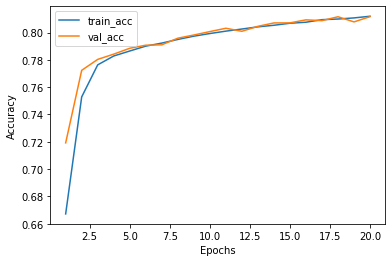

In [85]:
plt.plot(np.arange(1 , 21, 1), train_acc, label="train_acc")
plt.plot(np.arange(1 , 21, 1), val_acc, label="val_acc")

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [86]:
# prédiction des données
test_pred = model.predict(X_test)

# score du modèle
score = model.evaluate(X_test, y_test)
print(score)

# Prediction de l'échantillon de test
test_pred = model.predict(X_test)

test_pred_class = np.argmax(test_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)

print("Performances du modele :")
print(metrics.classification_report(y_test_class, test_pred_class))

9375/9375 [==============================] - 14s 2ms/step - loss: 0.4652 - accuracy: 0.8128
[0.4651585519313812, 0.8127666711807251]
Performances du modele :
              precision    recall  f1-score   support

           1       0.67      0.88      0.76     66970
           2       0.67      0.66      0.67     30517
           3       0.81      0.58      0.67     45902
           4       1.00      1.00      1.00    124986
           5       0.55      0.42      0.48     31625

    accuracy                           0.81    300000
   macro avg       0.74      0.71      0.72    300000
weighted avg       0.82      0.81      0.81    300000



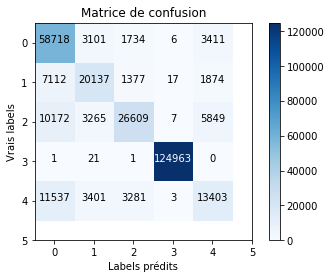

In [87]:
# affiche la matrice de confusion sous forme de tableau coloré
classes = range(0,6)

plt.figure()

# matrice de confusion
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# texte et couleur
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

